## Credit Card Fraud Detection using Classification and Clustering

### Context:
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content:
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Exploratory Data Analysis

In [2]:
data = pd.read_csv("creditcard.csv")

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
data.isnull().sum().max()

0

This dataset removed the names of the features to confidentiality reasons. Class is our variable of interest, or response variable that we are trying to predict

In [4]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [22]:
print(f"{round(data['Class'].value_counts()[1]/len(data)*100, 3)}% of transactions are fraudulent.")

0.173% of transactions are fraudulent.


In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
data['Amount'].mean()


88.34961925093133

<Axes: xlabel='Class', ylabel='Amount'>

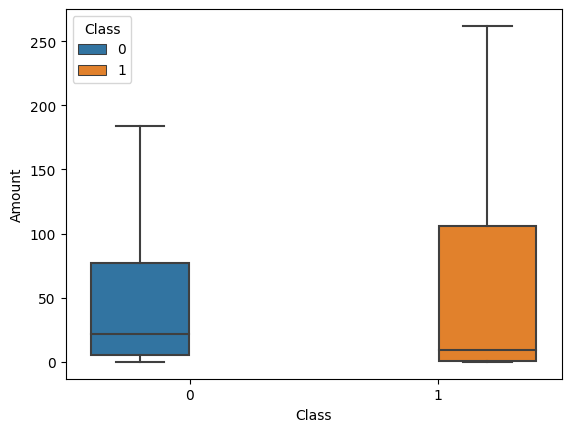

In [8]:
sns.boxplot(x="Class", y="Amount", hue="Class",data=data, showfliers =False)

Here we can see that fraudulent transactions seem to have more outliers. Let's explore this more

In [9]:
#Fraudulent Summary Stats
print(f"Fraudulent Mean: {data[data['Class'] == 1]['Amount'].mean()}")
print(f"Fraudulent Median: {data[data['Class'] == 1]['Amount'].median()}")
print(f"Fraudulent Min: {data[data['Class'] == 1]['Amount'].min()}")
print(f"Fraudulent Max: {data[data['Class'] == 1]['Amount'].max()}")
print(f"Fraudulent Standard Deviation: {data[data['Class'] == 1]['Amount'].std()}")
print("")
print(f"Non-Fraudulent Mean: {data[data['Class'] == 0]['Amount'].mean()}")
print(f"Non-Fraudulent Median: {data[data['Class'] == 0]['Amount'].median()}")
print(f"Non-Fraudulent Min: {data[data['Class'] == 0]['Amount'].min()}")
print(f"Non-Fraudulent Max: {data[data['Class'] == 0]['Amount'].max()}")
print(f"Non-Fraudulent Standard Deviation: {data[data['Class'] == 0]['Amount'].std()}")

Fraudulent Mean: 122.21132113821139
Fraudulent Median: 9.25
Fraudulent Min: 0.0
Fraudulent Max: 2125.87
Fraudulent Standard Deviation: 256.6832882977121

Non-Fraudulent Mean: 88.29102242231328
Non-Fraudulent Median: 22.0
Non-Fraudulent Min: 0.0
Non-Fraudulent Max: 25691.16
Non-Fraudulent Standard Deviation: 250.10509222589243


Text(0.5, 1.0, 'Non-Fraudulent Transactions')

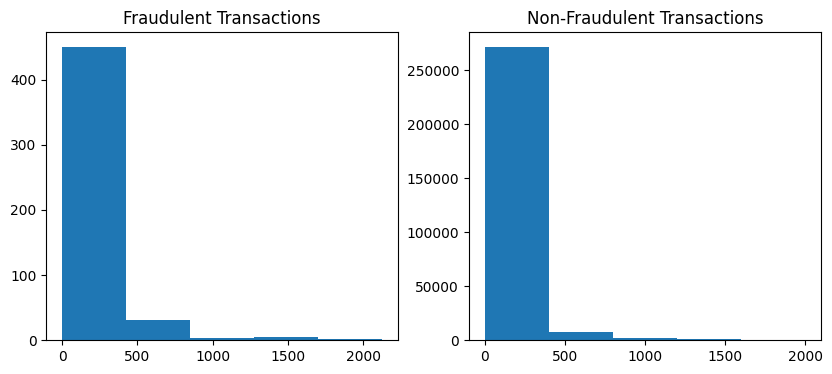

In [10]:
fraud_hist = data[data["Class"] == 1]['Amount']
#Showing amount under $2,500 to keep nonfraud on the same scale
nonfraud_hist = data[(data["Class"] == 0) & (data["Amount"] < 2000)]["Amount"]

fig, axs = plt.subplots(1,2, figsize =(10,4))

axs[0].hist(fraud_hist, bins =5)
axs[0].set_title("Fraudulent Transactions")

axs[1].hist(nonfraud_hist, bins =5)
axs[1].set_title("Non-Fraudulent Transactions")

Looking at our 5 number summary and histograms we can start to see that fraudulent transactions are much more right skewed as shown by mean > median. The two have similar stdev's but interesting the max fraudulent transaction was only $2,125. Let's explore the time feature to see if we can get more insight into what is typical of a fraudulent transaction.

Time is defined in the kaggle description as "the seconds elapsed between each transaction and the first transaction in the dataset"

<Axes: xlabel='Class', ylabel='Time'>

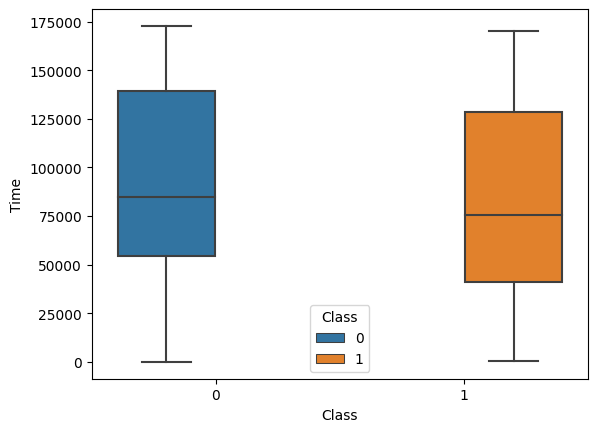

In [11]:
sns.boxplot(x = "Class", y = "Time", hue = "Class", data =data)

In [12]:
#Fraudulent Summary Stats
print(f"Time Fraudulent Mean: {data[data['Class'] == 1]['Time'].mean()}")
print(f"Time Fraudulent Median: {data[data['Class'] == 1]['Time'].median()}")
print(f"Time Fraudulent Min: {data[data['Class'] == 1]['Time'].min()}")
print(f"Time Fraudulent Max: {data[data['Class'] == 1]['Time'].max()}")
print(f"Time Fraudulent Standard Deviation: {data[data['Class'] == 1]['Time'].std()}")
print("")
print(f"Time Non-Fraudulent Mean: {data[data['Class'] == 0]['Time'].mean()}")
print(f"Time Non-Fraudulent Median: {data[data['Class'] == 0]['Time'].median()}")
print(f"Time Non-Fraudulent Min: {data[data['Class'] == 0]['Time'].min()}")
print(f"Time Non-Fraudulent Max: {data[data['Class'] == 0]['Time'].max()}")
print(f"Time Non-Fraudulent Standard Deviation: {data[data['Class'] == 0]['Time'].std()}")

Time Fraudulent Mean: 80746.80691056911
Time Fraudulent Median: 75568.5
Time Fraudulent Min: 406.0
Time Fraudulent Max: 170348.0
Time Fraudulent Standard Deviation: 47835.36513767505

Time Non-Fraudulent Mean: 94838.20225805884
Time Non-Fraudulent Median: 84711.0
Time Non-Fraudulent Min: 0.0
Time Non-Fraudulent Max: 172792.0
Time Non-Fraudulent Standard Deviation: 47484.01578555077


Here, we can see that Fraudulent Transactions occur closer to the first transaction.

Lastly, lets see how compenents V1,...,V28 relate to our Class variable.

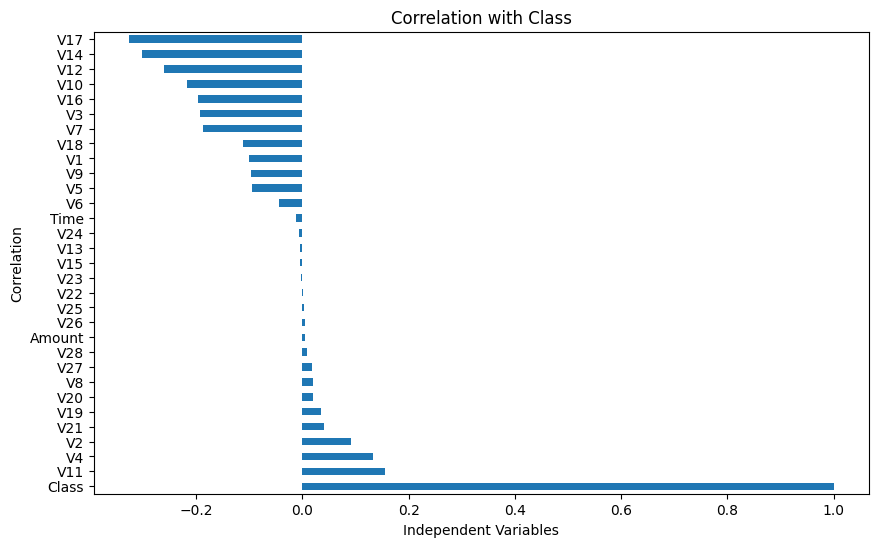

In [15]:
correlation_matrix = data.corrwith(data['Class'])
sorted_correlations = correlation_matrix.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_correlations.plot(kind='barh')
plt.title('Correlation with Class')
plt.xlabel('Independent Variables')
plt.ylabel('Correlation')
plt.show()